In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models
import models_redesign
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

2016-07-01 00:00:00
2018-06-26 19:00:00


<Axes: xlabel='date'>

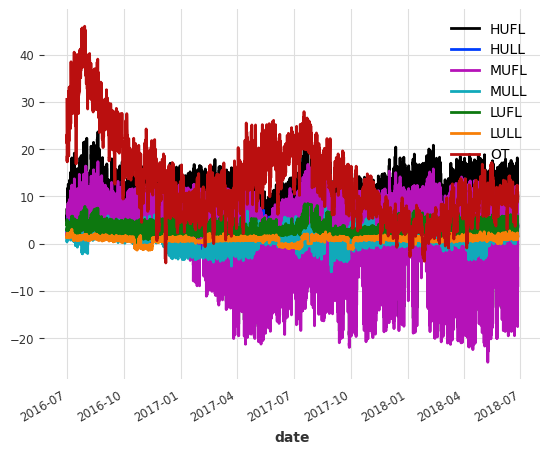

In [2]:
series = ETTh1Dataset().load()

print(series.start_time())
print(series.end_time())

series.plot()

In [3]:
train_series, test_series = series.split_before(0.6)
val_series, test_series = test_series.split_before(0.5)


In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [5]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 1024):
    scaler = StandardScaler()
    
    train, test = series.split_before(0.6)
    val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train_og = train.pd_dataframe()
    train = scaler.fit_transform(train_og)
    train = pd.DataFrame(train, columns=train_og.columns)
    X_train = train
    y_train = train[["OT"]]
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val_og = val.pd_dataframe()
    val = scaler.transform(val_og)
    val = pd.DataFrame(val, columns=val_og.columns)
    X_val = val
    y_val = val[["OT"]]
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test_og = test.pd_dataframe()
    test = scaler.transform(test_og)
    test = pd.DataFrame(test, columns=test_og.columns)
    X_test = test
    y_test = test[["OT"]]
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


In [6]:
seq_len = 10
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=24)

for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

print("Batches", len(train_loader), len(val_loader), len(test_loader))

Train/Val/Test 10451 3484 3485
torch.Size([1024, 10, 14])
torch.Size([1024, 24])
Batches 11 4 4


In [20]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    plt.xticks(xticks, history[:, 0])
    plt.yscale('log')

    for x,_y in zip(xticks, history[:, 2]):
        label = "{:.3f}".format(_y)
        plt.annotate(label, # this is the text
                    (x,_y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
        
    for x,_y in zip(xticks, history[:, 3]):
        label = "{:.3f}".format(_y)
        plt.annotate(label, # this is the text
                    (x,_y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()

def plot_prediction_vs_true(yb, preds, title):
    plt.plot(yb, color="black", label="True")
    plt.plot(preds, color="red", label="Pred")
    plt.title(title)
    plt.legend()
    plt.show()


In [8]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models_redesign.CBM_redesigned(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_redesign.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [9]:
random_seed = 1
set_seed(random_seed)


In [10]:
seq_len = 336
pred_len = 96
n_concepts_list = list(range(2,11,2)) + list(np.arange(100,301,100))
changing_dim = len(series.columns)
input_dim = 2 * changing_dim


## Original

In [11]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L{seq_len}-T{pred_len}/"
model_path_og = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 10451 3484 3485
n_concepts 2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c2.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=2, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[2, 0.05, 0.16399769484996796, 0.031181514263153076]

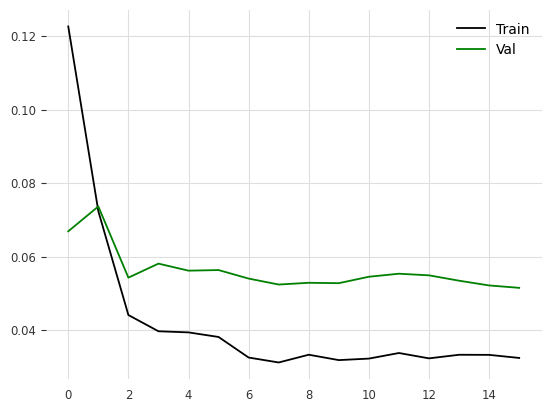

n_concepts 4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c4.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=4, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[4, 0.05, 0.16067664325237274, 0.030128220096230507]

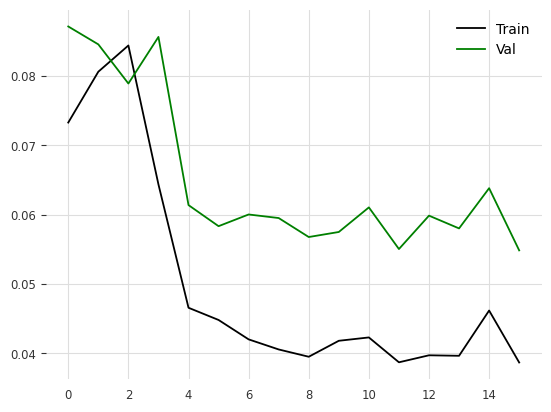

n_concepts 6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c6.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=6, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[6, 0.06, 0.16171927750110626, 0.03043779730796814]

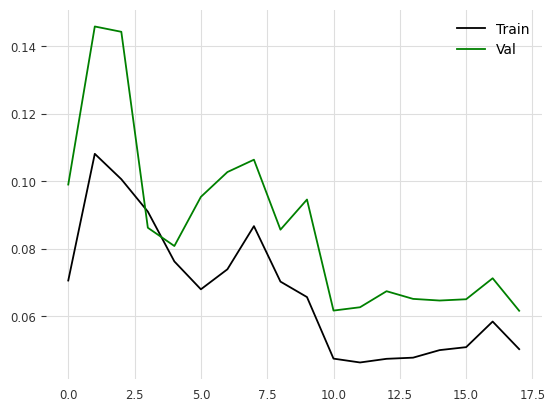

n_concepts 8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c8.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=8, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[8, 0.07, 0.1640065312385559, 0.03126096352934837]

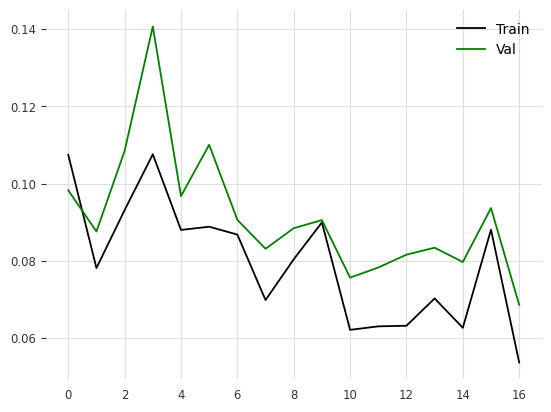

n_concepts 10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c10.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=10, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[10, 0.07, 0.14875911176204681, 0.026372894644737244]

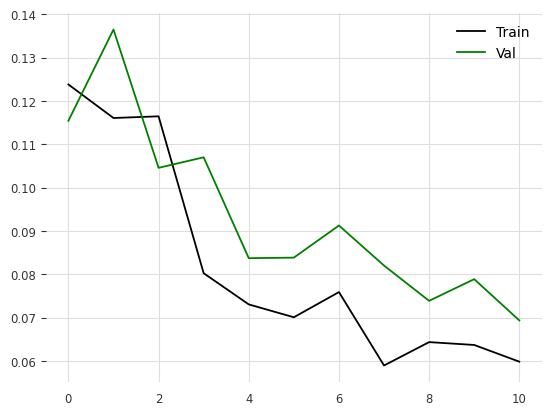

n_concepts 100
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c100.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=100, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[100, 0.43, 0.25317907333374023, 0.06920424103736877]

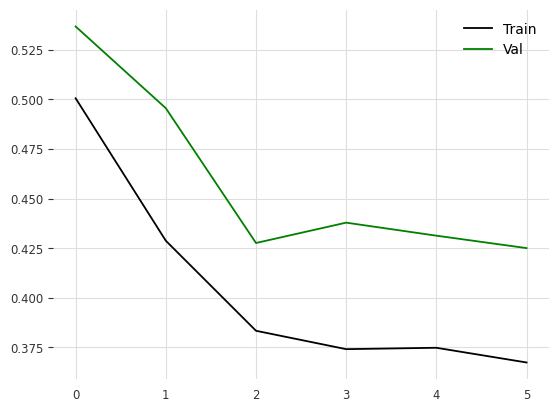

n_concepts 200
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c200.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=200, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[200, 0.74, 0.22116491198539734, 0.05420401319861412]

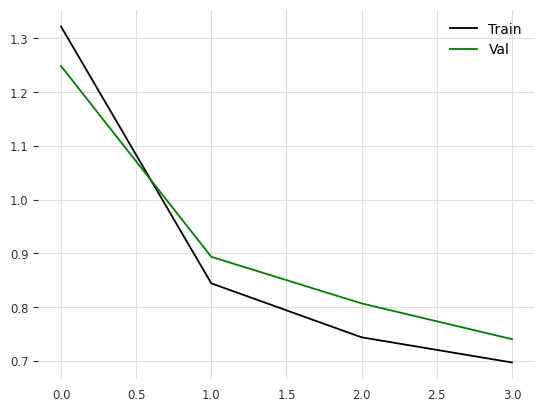

n_concepts 300
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c300.pt


CBM(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=4788, out_features=300, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[300, 1.1, 0.25194594264030457, 0.06899362057447433]

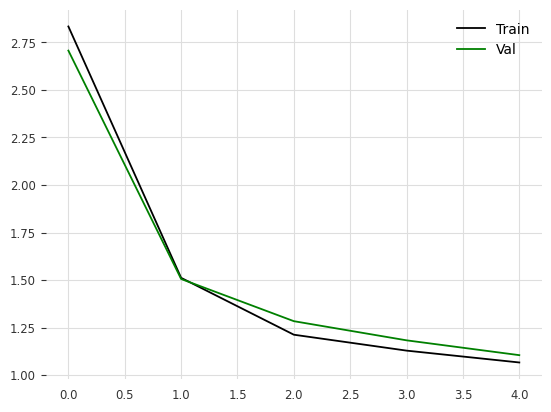

(8, 4)

In [12]:
history_og = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)
    
    display(model)
    
    model.eval()
    with torch.inference_mode():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_og.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_og = np.array(history_og)
history_og.shape


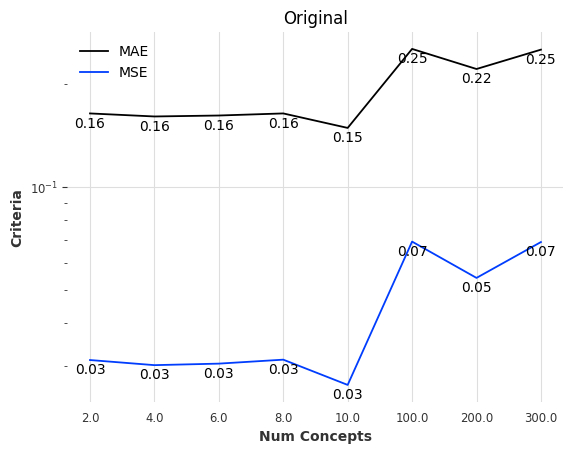

In [13]:
plot_mae_mse(history_og, "Original")


Train/Val/Test 10451 3484 3485
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L336-T96/forecasting_c10.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


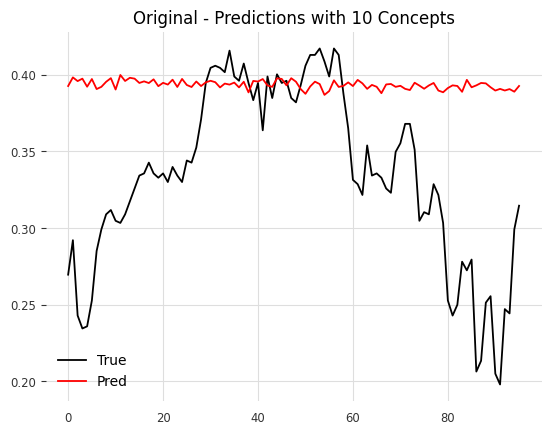

In [14]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 10

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Original - Predictions with {n_concepts} Concepts")


## Redesigned

In [15]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L{seq_len}-T{pred_len}/"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 10451 3484 3485
n_concepts 2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c2.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=2, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[2, 0.01, 0.05341716855764389, 0.004204848315566778]

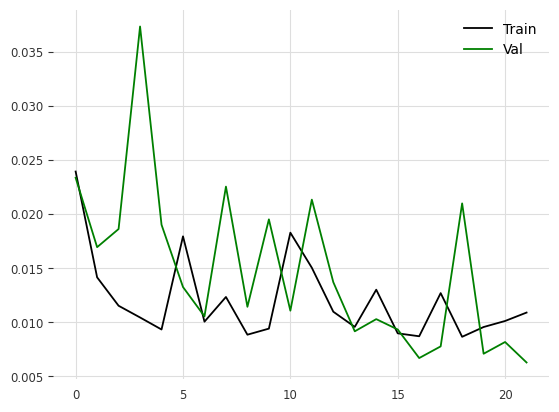

n_concepts 4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c4.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=4, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[4, 0.01, 0.049406398087739944, 0.0035826684907078743]

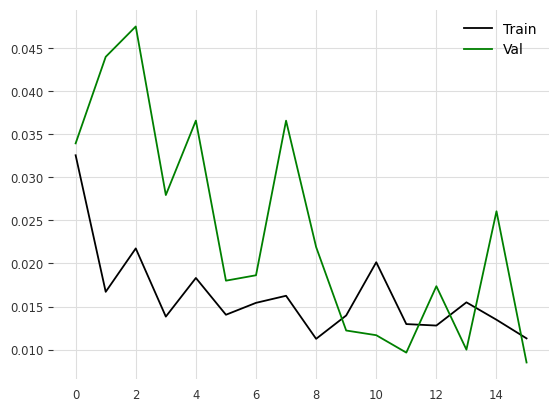

n_concepts 6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c6.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=6, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[6, 0.01, 0.05737309530377388, 0.004941457882523537]

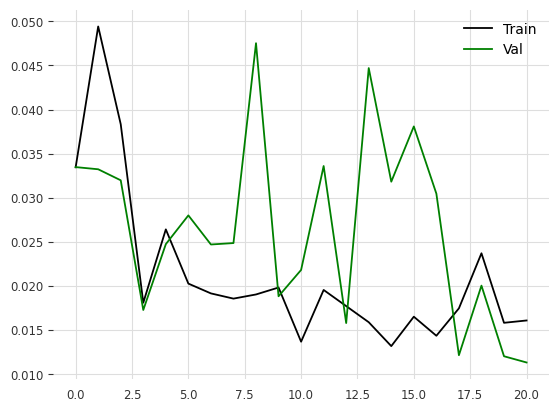

n_concepts 8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c8.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=8, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[8, 0.01, 0.050350748002529144, 0.003798650810495019]

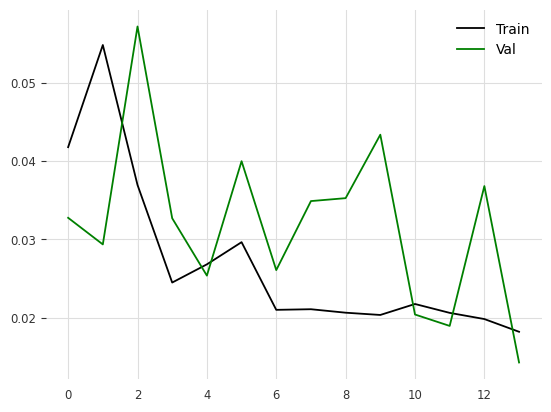

n_concepts 10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c10.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=10, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[10, 0.01, 0.0488223135471344, 0.0036548746284097433]

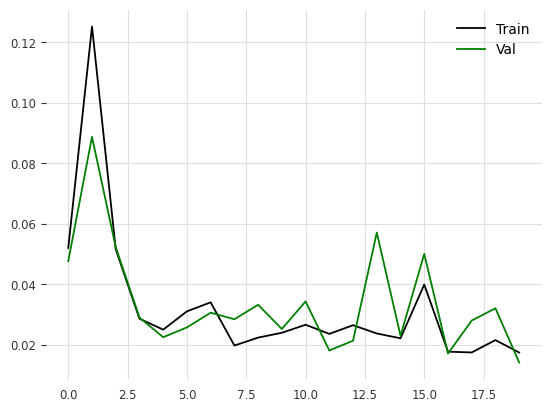

n_concepts 100
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c100.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=100, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[100, 0.14, 0.09005789458751678, 0.013118622824549675]

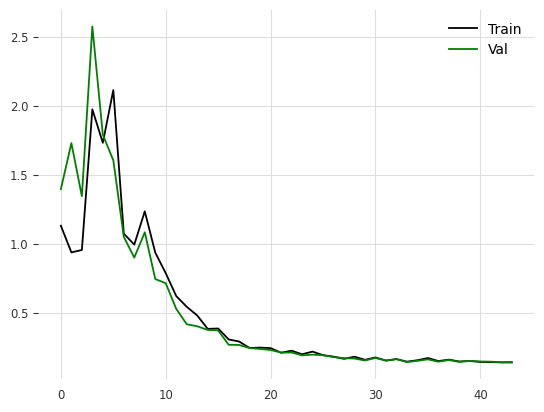

n_concepts 200
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c200.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=200, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[200, 0.34, 0.09769617021083832, 0.015321438200771809]

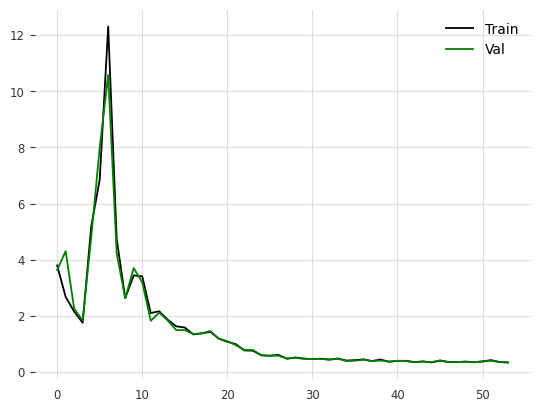

n_concepts 300
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c300.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=300, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[300, 0.69, 0.13048601150512695, 0.027083635330200195]

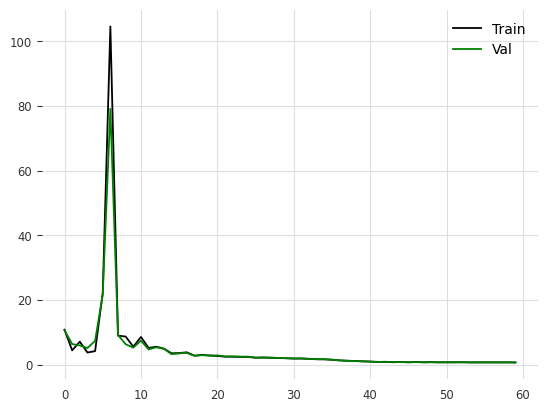

(8, 4)

In [16]:
history_re = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_re.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    torch.cuda.empty_cache()
    
history_re = np.array(history_re)
history_re.shape


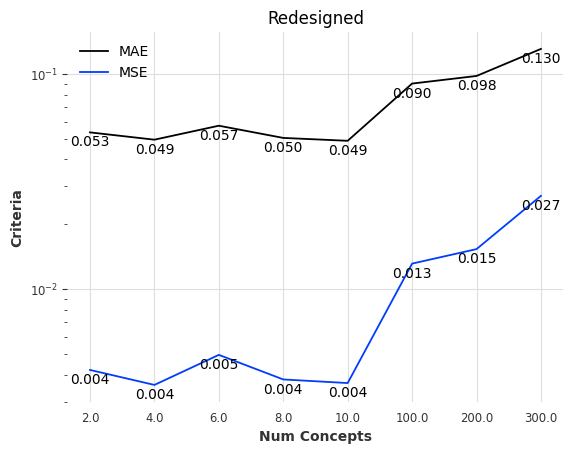

In [21]:
plot_mae_mse(history_re, "Redesigned")


Train/Val/Test 10451 3484 3485
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L336-T96/forecasting_c10.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


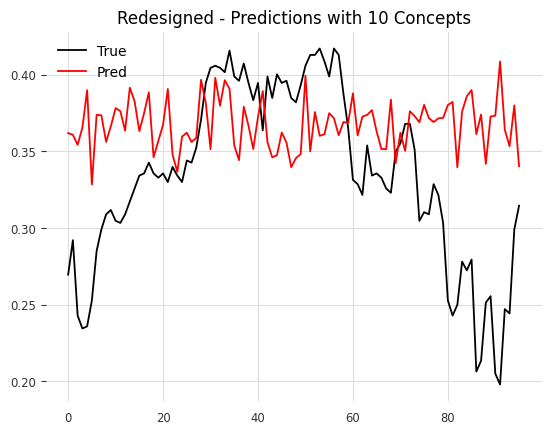

In [22]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 10

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts")


## Redesigned + LambdaLR as paper

In [19]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_lamdalr = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 10451 3484 3485
n_concepts 2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c2.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=2, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[2, 0.02, 0.08422061800956726, 0.010039140470325947]

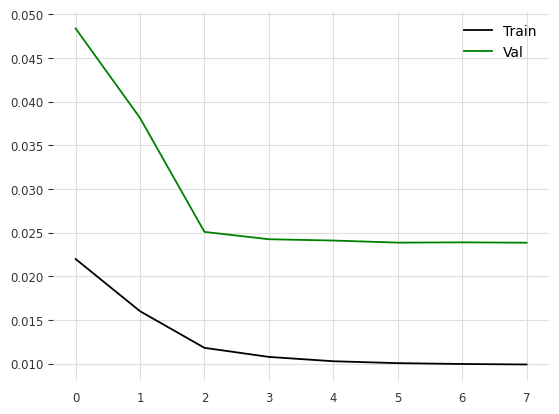

n_concepts 4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c4.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=4, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[4, 0.02, 0.055577006191015244, 0.004860332235693932]

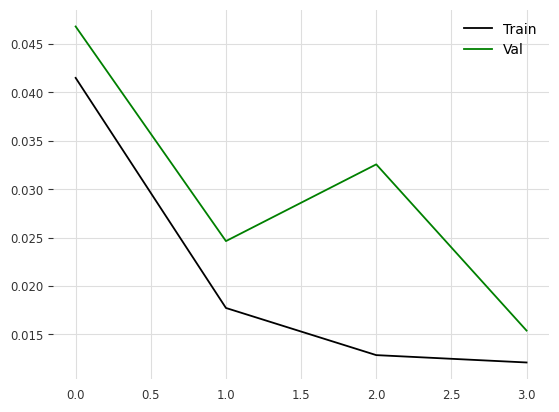

n_concepts 6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c6.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=6, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[6, 0.02, 0.057674065232276917, 0.005133741535246372]

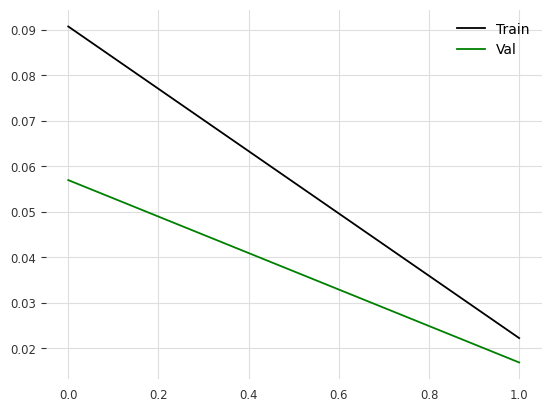

n_concepts 8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c8.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=8, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[8, 0.02, 0.05173575505614281, 0.0042845760472118855]

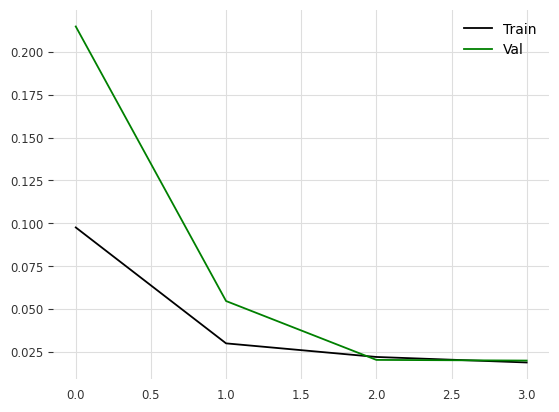

n_concepts 10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c10.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=10, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[10, 0.02, 0.04974772408604622, 0.00403094245120883]

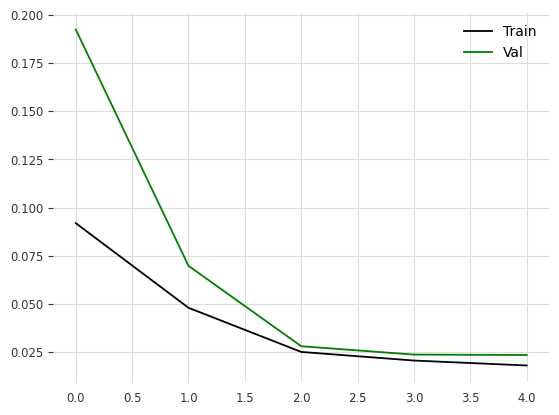

n_concepts 100
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c100.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=100, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[100, 1.48, 0.16913503408432007, 0.04430510476231575]

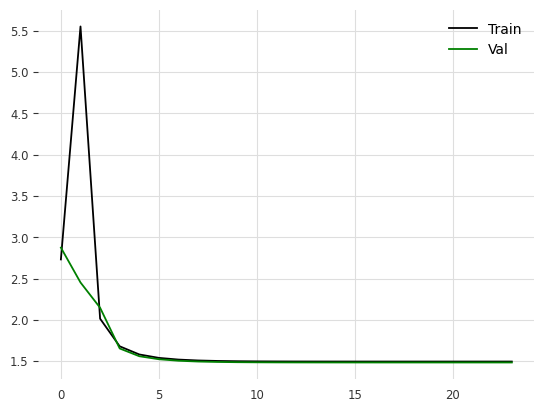

n_concepts 200
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c200.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=200, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[200, 4.53, 0.2772160470485687, 0.13180583715438843]

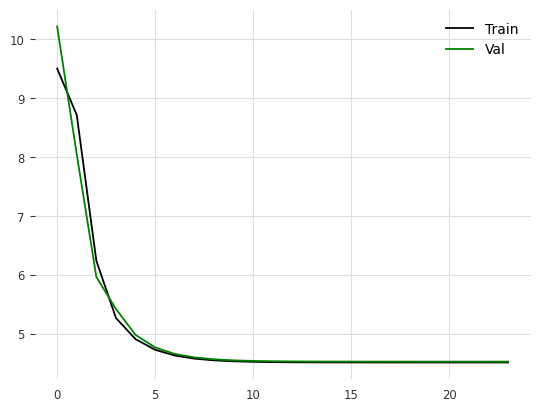

n_concepts 300
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-lambdalr-multi2single-L336-T96/forecasting_c300.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=300, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[300, 12.38, 0.48348915576934814, 0.44314199686050415]

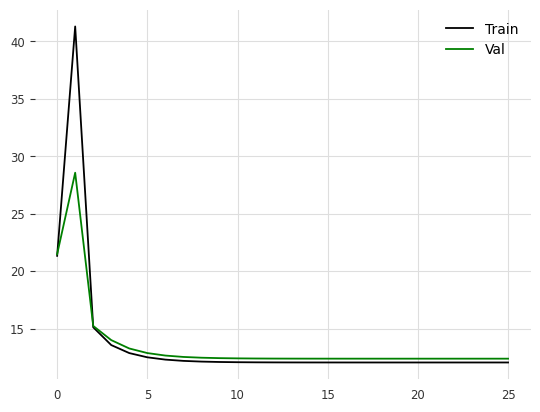

(8, 4)

In [20]:
history_re_lambdalr = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=5)
    lr_lambda = lambda epoch: 0.5 ** ((epoch - 1) // 1)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=model.optimizer, lr_lambda=lr_lambda)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re_lamdalr.format(n_concepts), max_epochs=10000, scheduler=scheduler)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_re_lambdalr.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    torch.cuda.empty_cache()
    
history_re_lambdalr = np.array(history_re_lambdalr)
history_re_lambdalr.shape


In [23]:
plot_mae_mse(history_re_lambdalr, "Redesigned + LambdaLR")


NameError: name 'history_re_lambdalr' is not defined

Train/Val/Test 10451 3484 3485


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


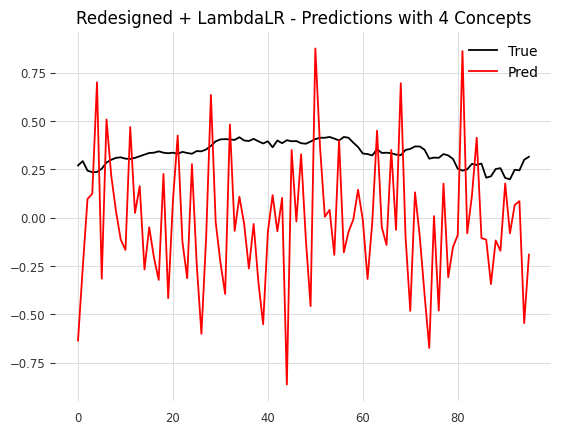

In [22]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 4

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
# model.fit(train_loader, val_loader, None, save_model_path=model_path_re_lamdalr.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned + LambdaLR - Predictions with {n_concepts} Concepts")


## Redesigned + ReduceLROnPlateau

In [23]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_reduceonplateau = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 10451 3484 3485
n_concepts 2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c2.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=2, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[2, 0.01, 0.051831748336553574, 0.004102405160665512]

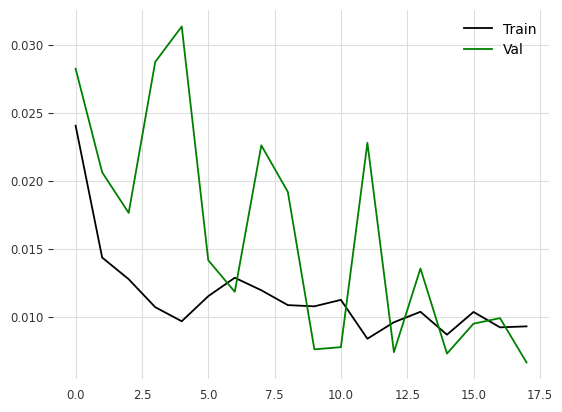

n_concepts 4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c4.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=4, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[4, 0.01, 0.05704071745276451, 0.004739569500088692]

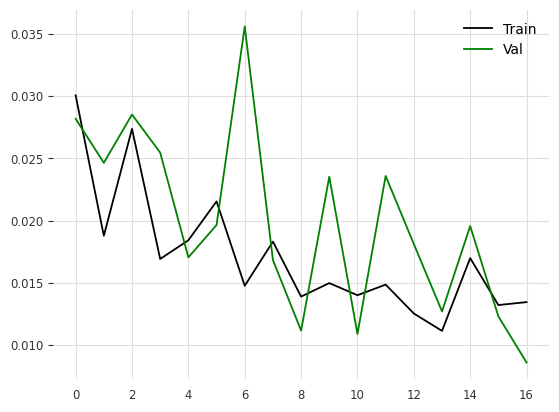

n_concepts 6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c6.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=6, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[6, 0.01, 0.049282439053058624, 0.0036108961794525385]

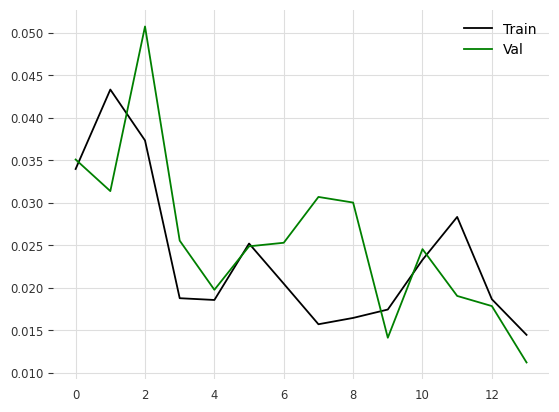

n_concepts 8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c8.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=8, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[8, 0.02, 0.055903032422065735, 0.005021959543228149]

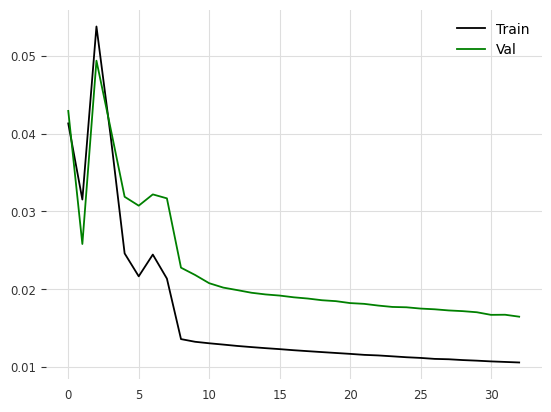

n_concepts 10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c10.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=10, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[10, 0.01, 0.0646970123052597, 0.006367994472384453]

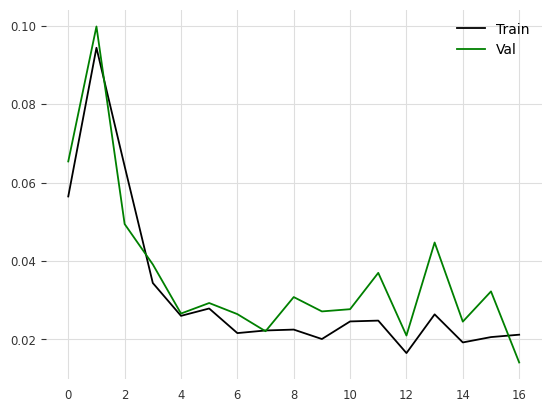

n_concepts 100
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c100.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=100, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[100, 0.03, 0.10307834297418594, 0.013567641377449036]

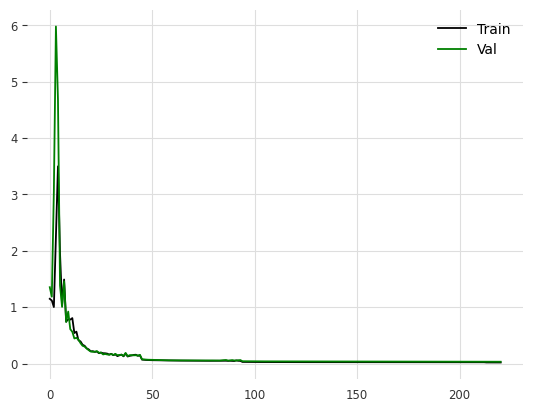

n_concepts 200
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c200.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=200, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[200, 2.55, 0.35135766863822937, 0.18542882800102234]

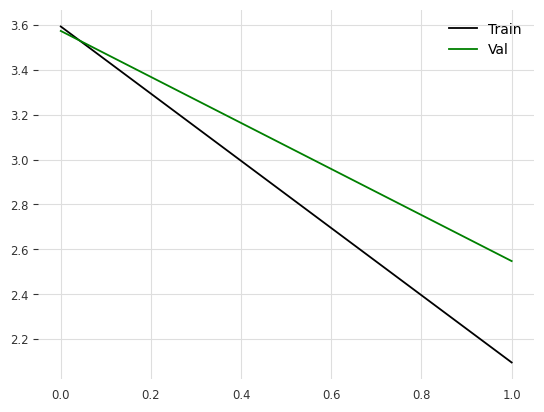

n_concepts 300
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-reduceonplateau-multi2single-L336-T96/forecasting_c300.pt


CBM_redesigned(
  (sigmoid_for_weights): Sigmoid()
  (sigmoid_for_ever_measured): Sigmoid()
  (upper_thresh_sigmoid): Sigmoid()
  (lower_thresh_sigmoid): Sigmoid()
  (output_af): Identity()
  (bottleneck): Linear(in_features=336, out_features=300, bias=True)
  (sigmoid_bottleneck): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): LazyLinear(in_features=0, out_features=96, bias=True)
)

[300, 3.29, 0.23820887506008148, 0.09140701591968536]

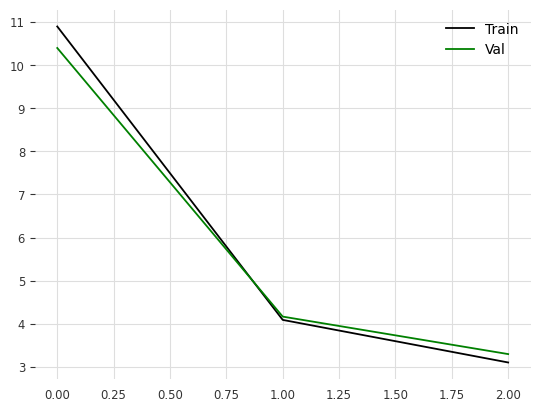

(8, 4)

In [24]:
history_re_reduceonplateau = []

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=5) # half patience of early stopping
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re_reduceonplateau.format(n_concepts), max_epochs=10000, scheduler=scheduler)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), mae, mse]
    display(history)
    history_re_reduceonplateau.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    torch.cuda.empty_cache()
    
history_re_reduceonplateau = np.array(history_re_reduceonplateau)
history_re_reduceonplateau.shape


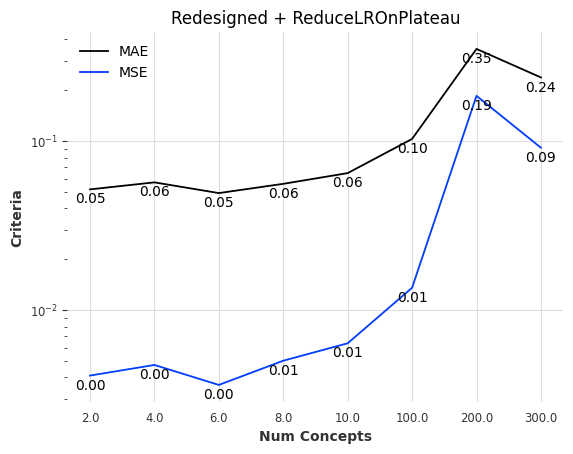

In [25]:
plot_mae_mse(history_re_reduceonplateau, "Redesigned + ReduceLROnPlateau")


Train/Val/Test 10451 3484 3485


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


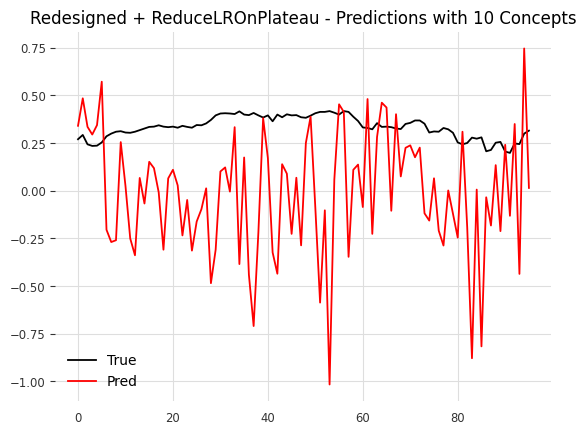

In [26]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 10

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
# model.fit(train_loader, val_loader, None, save_model_path=model_path_re_reduceonplateau.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plot_prediction_vs_true(yb, preds, title=f"Redesigned + ReduceLROnPlateau - Predictions with {n_concepts} Concepts")


## Optimization

In [27]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len)
model.fit(train_loader, val_loader, None, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

TypeError: initializeModel() missing 1 required positional argument: 'output_dim'

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
best_aucs, best_auc_inds, best_auc_concepts = greedy_selection(auroc_metric, test_loader, top_k_inds, model)


In [ ]:
filename = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Best AUC", "Best AUC Concept #", "Best AUC ind #"])
    # writing the data rows 
    for row in zip(best_aucs, best_auc_concepts, best_auc_inds):
        csvwriter.writerow(list(row))


## Multi-class

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_multiclass = []

set_seed(random_seed)

data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_ohe, multiclass=True)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
seq_len = data.shape[1]

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

for n_concepts in range(1,16):
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


In [ ]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head()

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"])
plt.plot(greedy_results["acc"])
plt.show()

In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", epochs=3000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)
